# **Import Library**


In [1]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval
import re
from datetime import datetime
from scipy.sparse import hstack

# **Dataset**

In [3]:
# Download dataset
url = 'https://drive.google.com/uc?id=1Cwyn6wG6OSP_o2n3kXx-En7axj7JDmyq'
output = 'IMDB_Top250_Tvshowst.csv'
gdown.download(url, output, quiet=False)

# Membaca dataset
df = pd.read_csv(output, encoding='latin-1')

Downloading...
From: https://drive.google.com/uc?id=1Cwyn6wG6OSP_o2n3kXx-En7axj7JDmyq
To: /content/IMDB_Top250_Tvshowst.csv
100%|██████████| 15.2k/15.2k [00:00<00:00, 13.7MB/s]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Titile          250 non-null    object 
 1   Year            250 non-null    object 
 2   Total_episodes  250 non-null    object 
 3   Age             244 non-null    object 
 4   Rating          250 non-null    float64
 5   Vote_count      250 non-null    object 
 6   Category        250 non-null    object 
dtypes: float64(1), object(6)
memory usage: 13.8+ KB


In [5]:
# Rename kolom Titile menjadi Title
df.rename(columns={'Titile': 'Title'}, inplace=True)

# **Data Cleaning & Preprocessing**

In [6]:
# Fungsi untuk membersihkan vote count
def clean_vote_count(vote_count):
    if isinstance(vote_count, str):
        # Hapus tanda kurung dan spasi
        vote_count = vote_count.strip("() ").replace(" ", "")
        # Cek apakah mengandung 'M' atau 'K'
        if vote_count.endswith('M'):
            try:
                vote_count = float(vote_count[:-1]) * 1_000_000
            except ValueError:
                vote_count = np.nan
        elif vote_count.endswith('K'):
            try:
                vote_count = float(vote_count[:-1]) * 1_000
            except ValueError:
                vote_count = np.nan
        else:
            try:
                vote_count = int(vote_count)
            except ValueError:
                vote_count = np.nan
    if pd.isna(vote_count):
        return 0
    else:
        return int(vote_count)

# Menerapkan fungsi ke kolom Vote_count
df['Vote_count'] = df['Vote_count'].apply(clean_vote_count)

# Membersihkan kolom Total_episodes: menghapus kata 'eps' dan spasi, kemudian konversi ke integer
df['Total_episodes'] = df['Total_episodes'].str.replace('eps', '', regex=False)
df['Total_episodes'] = df['Total_episodes'].str.strip()
df['Total_episodes'] = pd.to_numeric(df['Total_episodes'], errors='coerce').fillna(0).astype(int)

# Menangani nilai yang hilang pada kolom Age
df['Age'] = df['Age'].fillna('Unknown')

# **Eksplorasi Data**


Statistik Deskriptif:
       Total_episodes      Rating    Vote_count
count      250.000000  250.000000  2.500000e+02
mean        71.664000    8.761600  1.763600e+05
std        114.273149    0.228592  2.754837e+05
min          2.000000    8.500000  1.100000e+04
25%         15.000000    8.600000  3.400000e+04
50%         33.000000    8.700000  7.850000e+04
75%         77.750000    8.900000  2.047500e+05
max       1122.000000    9.500000  2.300000e+06


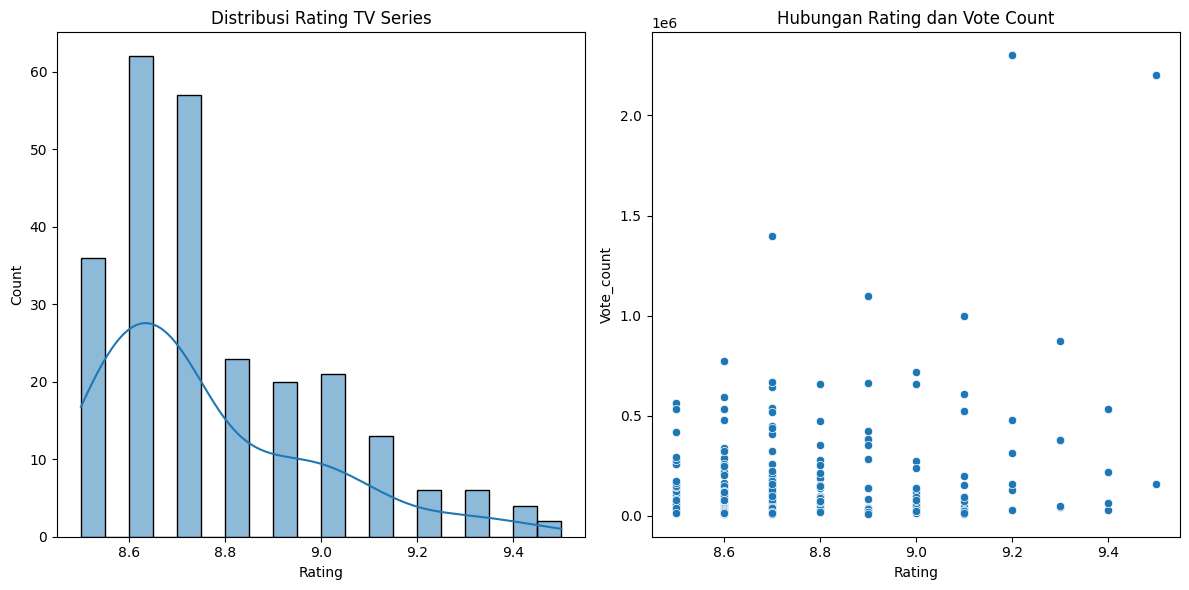

In [7]:
print("\nStatistik Deskriptif:")
print(df.describe())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribusi Rating TV Series')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Rating', y='Vote_count', data=df)
plt.title('Hubungan Rating dan Vote Count')
plt.tight_layout()
plt.show()

# **Data Preparation & Feature Engineering**

In [8]:
# Gabungkan fitur teks untuk TF-IDF
df['Metadata'] = df.apply(lambda x:
                         f"{x['Category']} {x['Age']} {'Series' if x['Total_episodes'] > 1 else 'Movie'}",
                         axis=1)

In [9]:
# Normalisasi fitur numerik
scaler = MinMaxScaler()
df[['Rating_scaled', 'Vote_count_scaled']] = scaler.fit_transform(df[['Rating', 'Vote_count']])

In [10]:
# Vektorisasi teks
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Metadata'])

In [11]:
# Gabungkan fitur
features = hstack([tfidf_matrix,
                  df[['Rating_scaled', 'Vote_count_scaled']].values])

# **Modeling (Content-Based Filtering)**

In [12]:
# Menghitung Cosine Similarity
cosine_sim = cosine_similarity(features, features)

# Fungsi Rekomendasi
def get_recommendations(title, cosine_sim=cosine_sim, df=df, top_n=5):
    try:
        # Mencari index film
        idx = df[df['Title'].str.lower() == title.lower()].index[0]

        # Mendapatkan skor similarity
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Mengurutkan film berdasarkan skor similarity
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Mengambil top_n rekomendasi (exclude film itu sendiri)
        sim_scores = sim_scores[1:top_n+1]

        # Mendapatkan indeks film
        movie_indices = [i[0] for i in sim_scores]

        # Return rekomendasi
        return df[['Title', 'Category', 'Rating', 'Age']].iloc[movie_indices]

    except IndexError:
        return "Film tidak ditemukan dalam database"

# **Evaluasi**

In [13]:
# Test Rekomendasi
sample_movie = df.sample(1)['Title'].values[0]
print(f"\nRekomendasi untuk film: {sample_movie}")
recommendations = get_recommendations(sample_movie)
print(recommendations)


Rekomendasi untuk film: 167. Greatest Events of WWII in Colour
                                                 Title        Category  \
119                                          120. 1883  TV Mini Series   
76                                     77. I, Claudius  TV Mini Series   
247                    248. Tear Along the Dotted Line  TV Mini Series   
232  233. RurÃ´ni Kenshin: Meiji kenkaku romantan -...  TV Mini Series   
139                                    140. It's a Sin  TV Mini Series   

     Rating Age  
119     8.7  15  
76      8.8  15  
247     8.6  15  
232     8.6  15  
139     8.6  15  


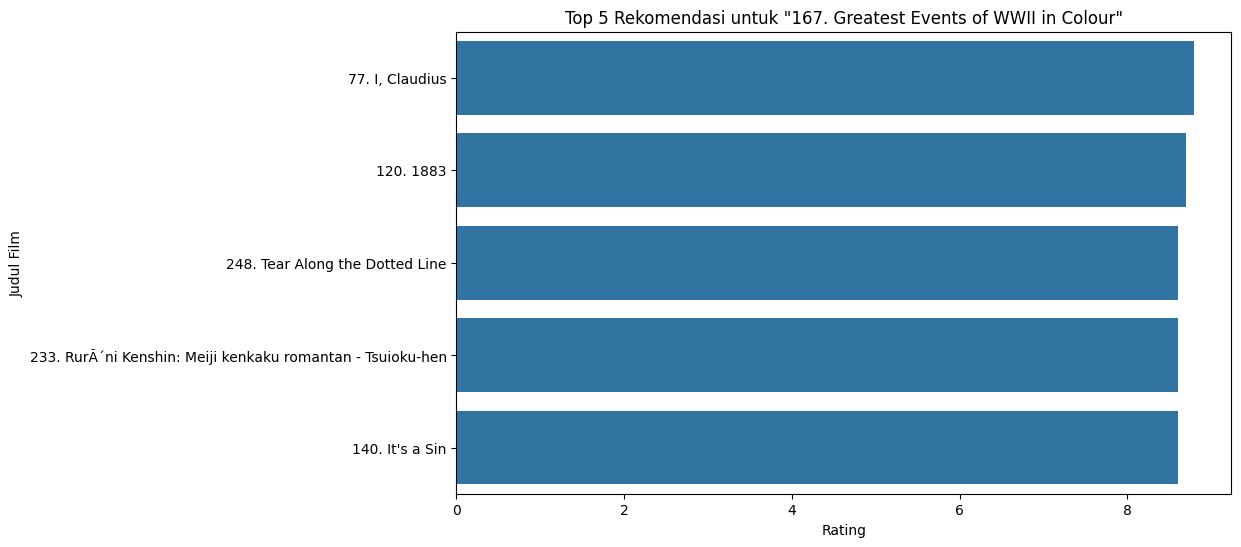

In [14]:
# Visualisasi Rekomendasi
plt.figure(figsize=(10, 6))
sns.barplot(x='Rating', y='Title', data=recommendations.sort_values('Rating', ascending=False))
plt.title(f'Top 5 Rekomendasi untuk "{sample_movie}"')
plt.xlabel('Rating')
plt.ylabel('Judul Film')
plt.show()